## Lemmatized Graph Analysis ##

In [118]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from community import best_partition
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wordcloud import WordCloud
from numpy import *
import numpy as np
import re
import json
import string
import time
import collections
import itertools

### Analysis Functions ###

In [3]:
def print_top_n(G,v, num):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.6f)' % (i+1,thenodes[nidx],score))
        #print '  %i. %s' % (i+1,G.node_object(idx))

In [4]:
# Takes in a graph and filters out all edges with a weight less than the input threshold. Returns a graph with only edges with weight greater than the threshold. All nodes with degree = 0 are removed.

def wtThreshold(G, threshold):
    G_wt = nx.Graph(G)
    for u,v in G_wt.edges():
        if G_wt[u][v]['weight'] < threshold:
            G_wt.remove_edge(u,v)
            
    # Remove all nodes with degree = 0
    remove = [node for node, deg in dict(G_wt.degree()).items() if deg == 0]
    G_wt.remove_nodes_from(remove)
    return G_wt

In [5]:
# Takes in a graph and filters out all components with size less than some threshold number of nodes. Returns a graph with only components of size greater than the threshold number of nodes.

def nodeThreshold(G, threshold):
    G_ct = nx.Graph(G)
    conn_comp_list = list(nx.connected_components(G_ct))
    for comp in conn_comp_list:
        if len(comp) < threshold:
            for node in comp:
                G_ct.remove_node(node)
    return G_ct

In [6]:
# Takes in a graph and computes the longest shortest path between any 2 nodes, and returns the diameter and the respective path

def diameter2(G):
    spaths = dict(nx.all_pairs_shortest_path(G))
    path = []
    diameter = 0
    for key in spaths:
        for val in spaths[key]:
            current = len(spaths[key][val])
            if current > diameter:
                diameter = current
                path = spaths[key][val]
    diameter = diameter - 1 # Because it counts the initial node, the diameter is 1 fewer
    return diameter, path

In [7]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

### Import Graph and begin analysis ###

In [266]:
G = nx.read_gml("shakespeare_lemmatized.gml")
# G = nx.read_gml("shakespeare_pos_3gram_fixed.gml")
# G = nx.read_gml("shakespeare_stemmed.gml")
G_und = G.to_undirected()

In [133]:
G2 = nx.read_gml("shakespeare_raw.gml")

In [267]:
print("Lemmatized: Nodes =",len(G.nodes()),", Edges = ",len(G.edges()))
# print("Stemmed: Nodes =",len(G.nodes()),", Edges = ",len(G.edges()))
print("Raw Graph: Nodes =",len(G2.nodes()),", Edges = ",len(G2.edges()))

Lemmatized: Nodes = 3893 , Edges =  7653
Raw Graph: Nodes = 4267 , Edges =  7676


## Centrality ##

In [265]:
cent = nx.degree_centrality(G)
cent_vals = list(cent.values())
print_top_n(G,cent_vals,30)

  1. IN DT NN (0.067572)
  2. DT JJ NN (0.064985)
  3. IN PRP$ NN (0.046233)
  4. NN IN NN (0.045910)
  5. DT NN NN (0.037181)
  6. IN JJ NN (0.035241)
  7. JJ NN NN (0.034594)
  8. DT NN IN (0.034271)
  9. IN DT JJ (0.031684)
  10. NN IN DT (0.028451)
  11. NN NN NN (0.026188)
  12. JJ NN IN (0.024248)
  13. VB DT NN (0.023925)
  14. NN CC NN (0.023602)
  15. NN IN JJ (0.022955)
  16. PRP$ JJ NN (0.022955)
  17. NN IN PRP$ (0.022308)
  18. NN TO VB (0.021985)
  19. IN PRP VBP (0.020045)
  20. PRP$ NN NN (0.019722)
  21. VB PRP$ NN (0.019075)
  22. VBZ DT NN (0.018752)
  23. IN PRP$ JJ (0.018429)
  24. JJ JJ NN (0.017782)
  25. IN NN NN (0.017459)
  26. NNS IN NN (0.017135)
  27. NN MD VB (0.016489)
  28. IN NN IN (0.016166)
  29. NN IN PRP (0.015842)
  30. PRP$ NN IN (0.015519)


In [263]:
bet_cent = nx.betweenness_centrality(G)
bet_cent_vals = list(bet_cent.values())
print_top_n(G,bet_cent_vals,30)

  1. love (0.111704)
  2. eye (0.061009)
  3. like (0.059475)
  4. make (0.045615)
  5. sweet (0.033618)
  6. heart (0.030092)
  7. beauti (0.027821)
  8. fair (0.027338)
  9. one (0.025928)
  10. death (0.024533)
  11. upon (0.024475)
  12. time (0.023831)
  13. still (0.023259)
  14. would (0.020101)
  15. see (0.019194)
  16. lip (0.016912)
  17. fear (0.016381)
  18. never (0.014857)
  19. day (0.014804)
  20. hand (0.014759)
  21. cheek (0.014559)
  22. come (0.014475)
  23. whose (0.013845)
  24. know (0.013821)
  25. kiss (0.013310)
  26. mine (0.012657)
  27. face (0.012292)
  28. made (0.011986)
  29. sun (0.011644)
  30. say (0.011478)


In [139]:
cent = nx.eigenvector_centrality(G)
cent_vals = list(cent.values())
# print_top_n(G,cent_vals,30)

# Find largest connected component
print("Number of connected components: ",nx.number_connected_components(G_und))
largest_cc = max(nx.connected_components(G_und), key=len)
# Create subgraph using the largest connected component
G_conn = G.subgraph(largest_cc)

[diam,path] = diameter2(G_conn)
print("Largest component Nodes = ",len(G_conn.nodes()),", Edges = ",len(G_conn.edges()))
print("Largest component diameter: ", diam)
print("Path: ",path)


Number of connected components:  54
Largest component Nodes =  3775 , Edges =  7586
Largest component diameter:  17
Path:  ['badness', 'reign', 'disturbing', 'jealousy', 'sour', 'taste', 'grief', 'one', 'kiss', 'die', 'sleep', 'witchcraft', 'charm', 'firm', 'soil', 'win', "wat'ry", 'main']


In [183]:
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(20, 100)

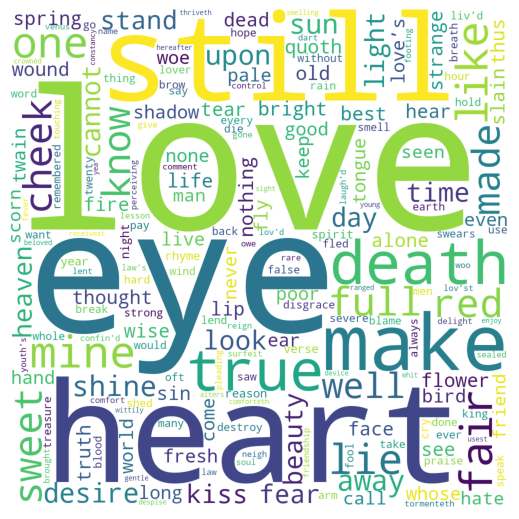

In [151]:
# Eigenvector Wordcloud
wordcloud = WordCloud(width = 1000, height = 1000, background_color ='white', min_font_size = 10).generate_from_frequencies(cent)
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# Show the plot
plt.savefig('eig_wordcloud.png')
plt.show()

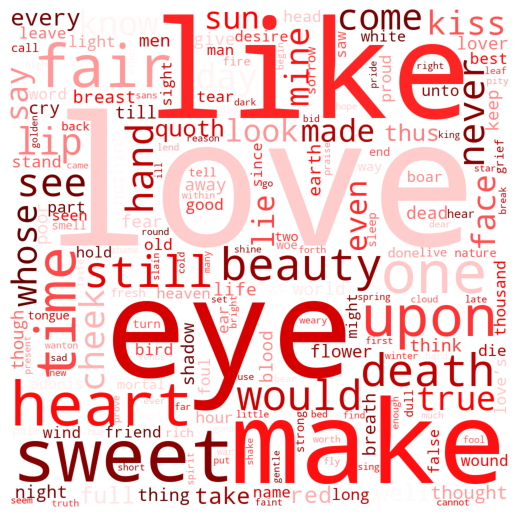

In [188]:
# Betweenness Wordcloud

wordcloud = WordCloud(width = 1000, height = 1000, background_color ='white', min_font_size = 10).generate_from_frequencies(bet_cent)
wordcloud.recolor(color_func = red_color_func)
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# Show the plot
plt.savefig('bet_wordcloud.png')
plt.show()

In [101]:
G_und = G_conn.to_undirected()

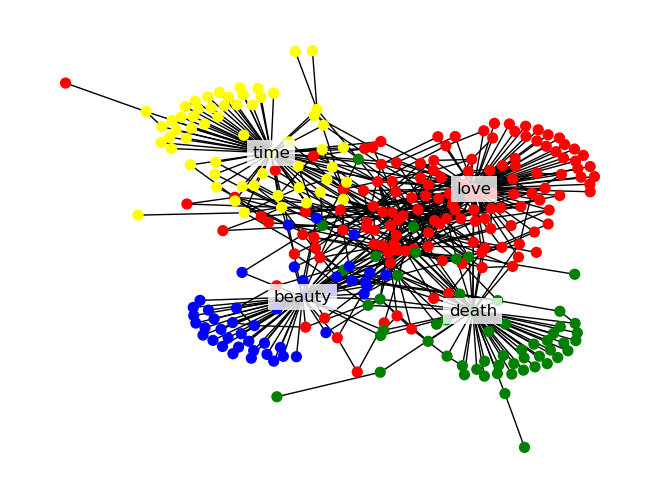

In [254]:
# Identified words: love, death, beauty, time

# Sort the nodes by centrality, from highest to lowest
sorted_nodes = sorted(cent, key=cent.get, reverse=True)

# Define the four reference words
reference_words = ['love', 'death', 'beauty', 'time']

# Create a dictionary to store the distances from each node to each reference node
distances = {}
for node in G_und.nodes:
    distances[node] = {}
    for word in reference_words:
        # Check if a path exists between the node and the reference word
        if nx.has_path(G_und, node, word):
            # Compute the shortest path length between the node and the reference word
            distance = nx.shortest_path_length(G_und, node, word)
            distances[node][word] = distance
        else:
            distances[node][word] = 1000

# Draw the new graph using a spring layout
pos = nx.spring_layout(H, seed=42)

# Define a color map based on the distances to the reference words and identify ref_word communities
color_map = []
love_comm = []
death_comm = []
beauty_comm = []
time_comm = []
for node in H.nodes:
    distances_to_ref_words = [distances[node][word] for word in reference_words]
    min_distance = min(distances_to_ref_words)
    if min_distance == 1000:
        color_map.append('gray')
    else:
        min_idx = distances_to_ref_words.index(min_distance)
        if min_idx == 0:
            color_map.append('red')
            love_comm.append(node)
        elif min_idx == 1:
            color_map.append('green')
            death_comm.append(node)
        elif min_idx == 2:
            color_map.append('blue')
            beauty_comm.append(node)
        else:
            color_map.append('yellow')
            time_comm.append(node)

# Draw the nodes with colors on a gradient based on their distances to the reference words
nx.draw(H, pos, node_color=color_map, node_size=50, with_labels=False)

# Add labels to the reference words
for word in reference_words:
    x, y = pos[word]
    plt.text(x, y, word, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# Show the graph
#plt.savefig('Node themes.jpg')
plt.show()

In [247]:
print(time_comm)

['time', 'tell', 'go', 'face', 'prefiguring', 'golden', 'thousand', 'devouring', 'blunt', 'waste', 'sluttish', 'decease', 'line', 'piping', 'peace', 'balmy', 'despite', 'among', "summer's", 'debateth', 'woe', 'advantage', 'wasted', 'calumniating', 'hope', 'gave', 'reflect', 'horror', 'boast', 'old', 'wonder', 'need', 'spend', 'little', 'lord', 'transfix', 'recorded', 'precious', 'clock', "remov'd", 'come', 'play', 'right', 'grow’st', 'man', 'hour', 'ring', 'decay', 'spent', 'riper', 'glance', 'wasteful', 'present', 'sent', 'bettering', 'swift-footed', 'ruining', 'exchanged']


## Community Detection ##

In [12]:
G_und = G2.to_undirected()
#cset = list(nx_comm.greedy_modularity_communities(G_und))
cset = list(nx_comm.label_propagation_communities(G_und))

In [107]:
print(len(cset))

1313


Text(0.5, 1.0, 'Communities for unfiltered Shakespeare graph')

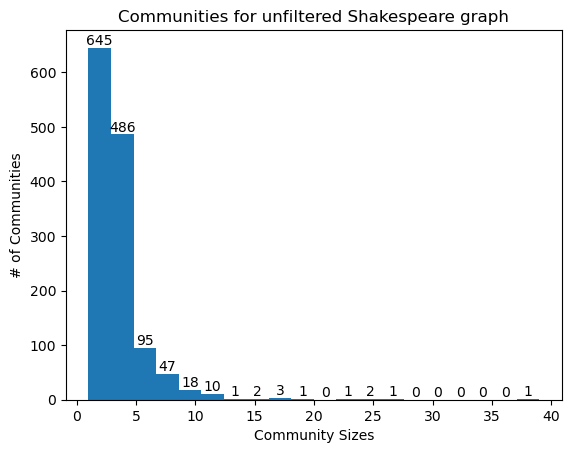

In [16]:
commSizeList = []
for comm in cset:
    commSizeList.append(len(comm))
    
values, bins, bars = plt.hist(commSizeList,20)
plt.xlabel('Community Sizes')
plt.ylabel('# of Communities')
plt.bar_label(bars)
plt.title('Communities for unfiltered Shakespeare graph')

Text(0.5, 1.0, 'Communities for Min Edge weight = 3')

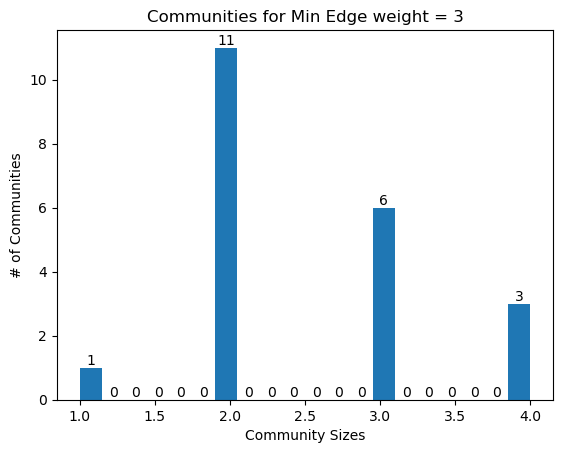

In [17]:
# Implement weight thresholds to filter graph:
wt = 3

G_wt = wtThreshold(G_und,wt)
#cset_wt = list(nx_comm.greedy_modularity_communities(G_wt))
cset_wt = list(nx_comm.label_propagation_communities(G_wt))

commSizeList = []
for comm in cset_wt:
    commSizeList.append(len(comm))
    
values, bins, bars = plt.hist(commSizeList,20)
plt.xlabel('Community Sizes')
plt.ylabel('# of Communities')
plt.bar_label(bars)
plt.title(f'Communities for Min Edge weight = {wt}')

In [18]:
print(cset_wt)

[{'pretty', 'ring', 'springtime', 'time'}, {'eyes', 'see'}, {'cuckoo', 'day', 'every', 'tree'}, {'night', 'good'}, {'eye', 'mine', 'ear'}, {'love', 'still', 'spring'}, {'boy', 'sweet', 'lovers'}, {'rain', 'raineth'}, {'brutus', 'honourable', 'man'}, {'note', 'merry'}, {'one'}, {'says', 'ambitious'}, {'like', 'two'}, {'mocks', 'unpleasing', 'married', 'men'}, {'hither', 'dust', 'come'}, {'thus', 'sings'}, {'word', 'fear'}, {'fire', 'burn'}, {'wind', 'ho'}, {'sing', 'birds'}, {'nonino', 'hey', 'ding'}]


Text(0.5, 1.0, 'Communities for Min community size = 10')

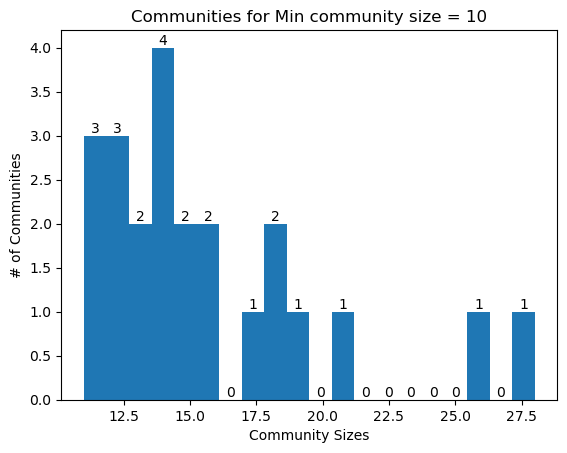

In [205]:
# Implement node threshold for communities

ct = 10
#G_ct = nodeThreshold(G_und,ct)

#cset_ct = list(nx_comm.greedy_modularity_communities(G_ct))
cset_ct = list(nx_comm.label_propagation_communities(G_und))

cset_ct2 = []
for comm in cset_ct:
    if len(comm) > ct:
        cset_ct2.append(comm)

commSizeList = []
for comm in cset_ct2:
    commSizeList.append(len(comm))
    
values, bins, bars = plt.hist(commSizeList,20)
plt.xlabel('Community Sizes')
plt.ylabel('# of Communities')
plt.bar_label(bars)
plt.title(f'Communities for Min community size = {ct}')

In [236]:
print(cset_ct2)

[{'took', 'fear', 'need', 'cause', 'mistrust', 'minion', 'lose', 'whereof', 'wait', 'lurk', 'cuckoo', 'prophetic', 'summer’s', 'repel', 'slander', 'heat', 'step', 'frown', 'pleasure', 'hear', 'áccessory', 'walk', 'word', 'paying', 'love’s', 'oh'}, {'book', 'hateful', 'travel', 'divorce', 'jealous', 'honour', 'quite', 'razed', 'fashion', 'add', 'undone', 'whereat', 'question', 'sudden'}, {'cannon', 'near', 'brass', 'slain', 'eternal', 'died', "cancell'd", 'fond', 'hemm’d', 'reft', 'spite', 'deer', 'unkind', 'since', 'park', 'tomb'}, {'hearing', 'end', 'die', 'delight', 'glory', 'opposing', 'charge', 'world-without', 'journey', 'aptly', "fever's", 'anew', "body's"}, {'acquainted', 'bail', 'heart', 'beshrew', 'knock', 'teen', 'prison', 'serving', 'obsequious', 'guard', 'boding', 'drumming', 'command', 'throbbing'}, {'heating', 'blood', 'mingled', 'stole', 'congealed', 'smoke', 'grosser', 'fet', "baboon's", 'summon', 'milk', 'next', 'flesh', 'cool'}, {'stillitory', 'hairless', 'excelling',

Text(0.5, 1.0, 'Louvain Communities for Min community size = 25')

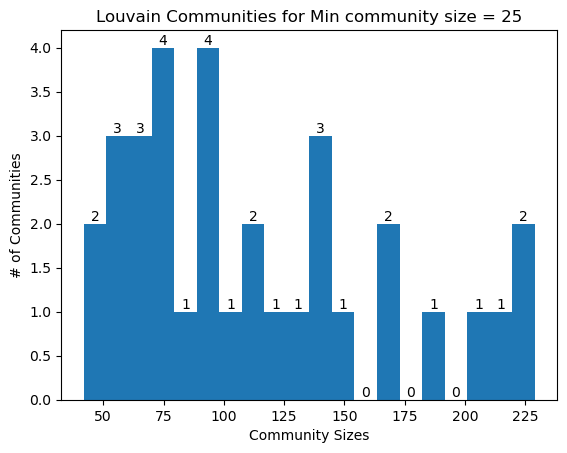

In [200]:
cset_louvain = nx_comm.louvain_communities(G_und) # Do not run for directed graph version

ct = 25
cset_louvain_ct = []
for comm in cset_louvain:
    if len(comm) > ct:
        cset_louvain_ct.append(comm)

commSizeList = []
for comm in cset_louvain_ct:
    commSizeList.append(len(comm))
    
values, bins, bars = plt.hist(commSizeList,20)
plt.xlabel('Community Sizes')
plt.ylabel('# of Communities')
plt.bar_label(bars)
plt.title(f'Louvain Communities for Min community size = {ct}')

In [243]:
print(f"Number of communities in unfiltered graph using Louvain: {len(cset_louvain)}")
print(f"Number of communities with minimum community size = {ct}: {len(cset_louvain_ct)}")


cset_louvain_sorted = sorted(cset_louvain_ct, key=len, reverse=True)
print(cset_louvain_sorted[-2])

Number of communities in unfiltered graph using Louvain: 86
Number of communities with minimum community size = 10: 33
{'stonish’d', 'night-wanderers', 'wive', 'fadeth', 'ingratitude', 'begets', 'came', 'ache', 'mould', 'provoke', 'monster', "dimm'd", 'dug', 'task', 'dumbly', 'pause', 'ended', 'respect', 'often', 'desiring', 'passion', 'nought', 'sunset', 'great-sized', 'scope', 'esteem', 'unseen', 'stealing', 'distress’d', 'gold', 'throng', 'swelling', 'doteth', 'constant', 'franticly', 'mightst', 'man’s', 'estate', 'complexion', 'master-mistress', 'worldly', 'variable', 'entertain’d', 'west', 'disturb', 'deeply', 'burnish’d', 'redoubled', 'wayward', 'ala'}


In [94]:
G_cset = G_und
G_cset.remove_nodes_from([n for n in G_cset if n not in cset_louvain_ct[1]])

print(len(G_und.nodes()))

cset_in = list(nx_comm.label_propagation_communities(G_cset))

203


In [104]:
print(cset_in)

[{'meed', 'cries', 'favour', 'savour', 'deign'}, {'seeks', 'dry'}, {'shame', 'cynthia', 'all-eating', 'frosty'}, {'compared', 'grief', 'express', 'droop'}, {'flattery', 'purple', 'salt', 'children’s', 'chorus-like', 'tears', 'pearl'}, {'guess', 'forbid', 'shore', 'adding', 'one', 'dissuade', 'halfworld', 'essence'}, {'works', 'comforteth', 'pard', 'like', 'bewitching', 'lurk’d', 'featured', 'shone', 'showed', 'melted', 'dial-hand', 'tooth’d', 'show’d', 'circumstance'}, {'wild', 'waves', "swill'd"}, {'many', 'alexanders'}, {'swords', 'sheathed', 'marigolds'}, {'tongues', 'argument', 'lack'}, {'single', "nature's", 'husband', 'mischief', 'rarities', 'glutton-like', 'feeds'}, {'thing', 'foolish', 'remuneration'}, {'ladies', 'praise', 'thriftless', 'consent'}, {'exclaims', 'sighing'}, {'heard', 'furnace', 'woeful', 'ballad', 'ditty', 'extemporally'}, {'perchance', 'dream', 'behind', 'proposed'}, {'ay', 'rub'}, {'tunes', 'trembles', 'tale'}, {'mail', 'rusty'}, {'abreast', 'musits', 'where’e

## Degree Distribution ##

In [110]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

def calc_powerlaw(G,kmin=None):
    ddist = degree_distribution(G,normalize=False)
    cdist = cumulative_degree_distribution(G)
    k = arange(len(ddist))
    
    # Compute N and obtain ki vector
    deg_seq = degree_sequence(G)
    ki_vec = []
    N = 0
    for i,n in enumerate(deg_seq):
        if n >= kmin:
            ki_vec.append(n)
            N += 1
    
    # Compute the summation term
    ln_sum = 0
    for ki in ki_vec:
        ln_sum = ln_sum + np.log(ki/(kmin - 0.5))
    
    alpha = 1 + N*(1/ln_sum) # calculate using Newman (8.6)!
    sigma = (alpha - 1)/sqrt(N) # calculate using Newman (8.7)!
    print( '%1.2f +/- %1.2f' % (alpha,sigma) )

    plt.figure(figsize=(8,12))
    plt.subplot(211)
    plt.bar(k,ddist, width=0.8, bottom=0, color='b') # replace xvalues and barheights!

    plt.subplot(212)
    plt.loglog(k,cdist) # replace xvalues and yvalues!
    plt.axvline(kmin,color = 'r')
    plt.grid(True)

2.59 +/- 0.09


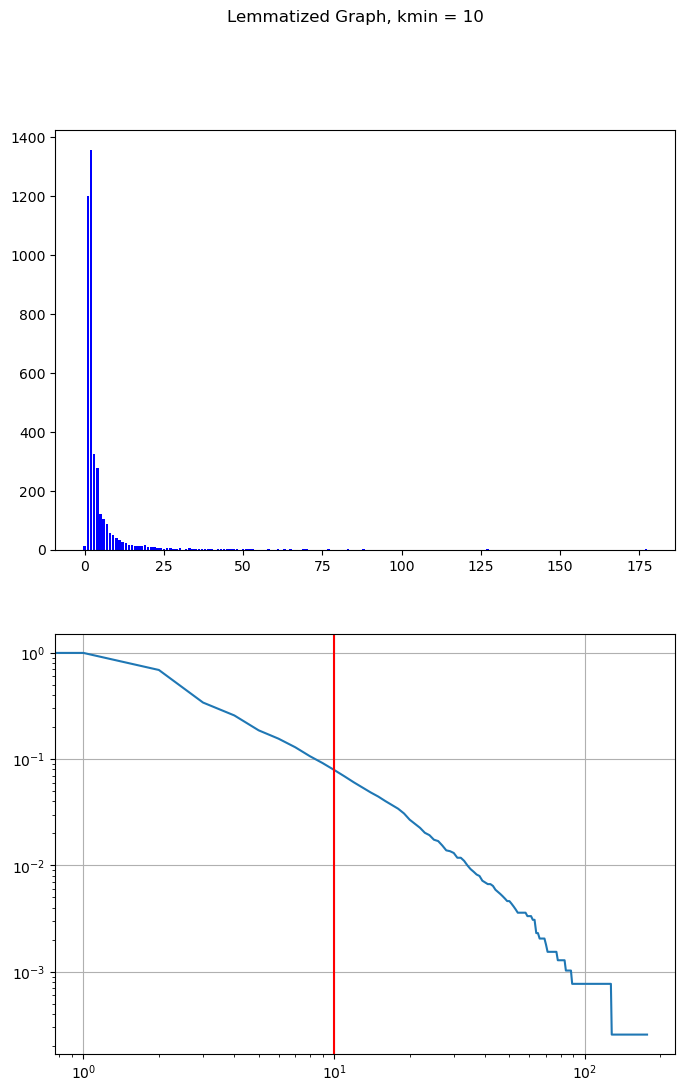

In [116]:
calc_powerlaw(G,10) # select kmin!
plt.suptitle("Lemmatized Graph, kmin = 10")
plt.show()